In [31]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [2]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-03 16:22:25,671 INFO: Initializing external client
2025-03-03 16:22:25,672 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-03 16:22:27,339 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1213637


In [3]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1213637/featurestores/1201260/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [4]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.68s) 


In [5]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [6]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00+00:00,2,0
1,2023-01-01 01:00:00+00:00,2,0
2,2023-01-01 02:00:00+00:00,2,0
3,2023-01-01 03:00:00+00:00,2,0
4,2023-01-01 04:00:00+00:00,2,0


In [7]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [8]:
ts_data["pickup_hour"].max()

'2025-03-03 21:00:00+00:00'

In [9]:
ts_data_copy = ts_data.copy()

In [10]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [11]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632951 entries, 0 to 2632950
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 40.2 MB


In [12]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [13]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632951 entries, 0 to 2632950
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 40.2 MB


In [14]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [15]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2632946,2025-03-03 17:00:00,263,114,2025-03
2632947,2025-03-03 18:00:00,263,116,2025-03
2632948,2025-03-03 19:00:00,263,102,2025-03
2632949,2025-03-03 20:00:00,263,87,2025-03


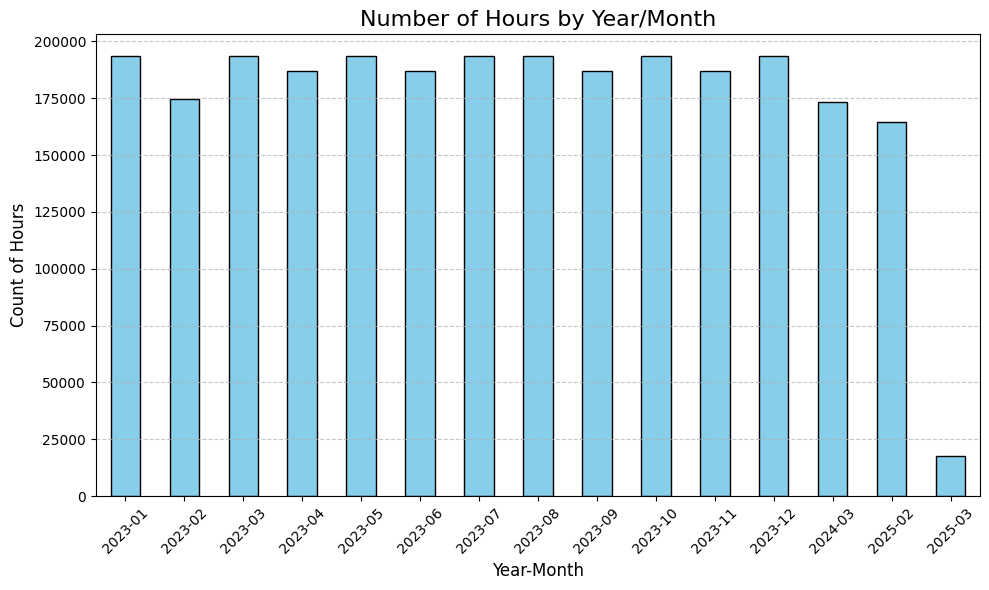

In [16]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [17]:
ts_data.head()      

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01


In [18]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [19]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [20]:
filtered_data.shape

(2277600, 3)

In [21]:
ts_data = filtered_data

In [22]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277600 entries, 0 to 2277599
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 34.8 MB


In [23]:
ts_data.head()["pickup_hour"].values

array(['2023-01-01T00:00:00.000000000', '2023-01-01T01:00:00.000000000',
       '2023-01-01T02:00:00.000000000', '2023-01-01T03:00:00.000000000',
       '2023-01-01T04:00:00.000000000'], dtype='datetime64[ns]')

In [24]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [25]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [26]:
features[features["pickup_location_id"] == 2]

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-27 13:00:00,2
348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-28 12:00:00,2
349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-29 11:00:00,2
350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-12-30 10:00:00,2


In [27]:
features_copy = features.copy()

In [28]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [29]:
from datetime import datetime, timedelta  
import pandas as pd  
from src.data_utils import split_time_series_data  

# Define the cutoff date as 28 days before today  
cutoff_date = pd.Timestamp(datetime.now() - timedelta(days=28))  
# # Convert the cutoff date to a string in a specific format (e.g., 'YYYY-MM-DD')  
# cutoff_date_str = cutoff_date.strftime('%Y-%m-%d')
# # Print the string representation of the cutoff date  
# print(f"Cutoff date as string: {cutoff_date_str}")
cutoff_date

Timestamp('2025-02-03 16:23:01.778733')

In [45]:
features_targets

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id,target
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,2023-01-29 00:00:00,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-29 23:00:00,2,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-30 22:00:00,2,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-01-31 21:00:00,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2023-02-01 20:00:00,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,38,37,68,74,98,85,89,2023-12-27 13:00:00,263,81
91516,104,109,89,133,130,143,165,103,106,111,...,14,30,34,49,76,96,88,2023-12-28 12:00:00,263,86
91517,100,114,110,117,134,130,188,250,173,142,...,8,11,38,46,55,73,73,2023-12-29 11:00:00,263,69
91518,151,148,147,134,119,137,124,126,160,205,...,13,14,16,20,25,42,54,2023-12-30 10:00:00,263,82


In [46]:
df=features_targets.copy()

In [47]:
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df.set_index('pickup_hour', inplace=True)

# Step 1: Define Features and Target
features = df.drop(columns=['target'])  # Drop target to get only features
target = df['target']

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary. Differencing is needed.")

check_stationarity(target)

# Step 3: Differencing if data is not stationary
if adfuller(target.dropna())[1] > 0.05:
    target = target.diff().dropna()
    print("Applied differencing.")
    check_stationarity(target)

# Step 4: Train-Test Split (80-20 split)
train_size = int(len(df) * 0.8)
X_train, X_test = features.iloc[:train_size], features.iloc[train_size:]
y_train, y_test = target.iloc[:train_size], target.iloc[train_size:]

ADF Statistic: -10.763783505676946
p-value: 2.4822588636679625e-19
Data is stationary.


In [49]:
auto_model = auto_arima(y_train, X=X_train, seasonal=False, trace=True, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

# Extract best (p,d,q) values
p, d, q = auto_model.order



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=496290.439, Time=514.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=580413.314, Time=2521.66 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=496283.159, Time=779.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=496283.169, Time=644.67 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=496284.029, Time=1283.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=496285.059, Time=2328.44 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=496286.248, Time=2188.86 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=496285.152, Time=500.87 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 10762.597 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                73216
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -247466.579
Date:                Mon, 03 Mar 2025   AIC                         496283.

In [50]:
# Step 6: Fit ARIMA Model with Features
model = ARIMA(y_train, exog=X_train, order=(p, d, q))
arima_result = model.fit()
print(arima_result.summary())

# Step 7: Forecast on test data
y_pred = arima_result.forecast(steps=len(y_test), exog=X_test)

# Step 8: Evaluate using MAE
mae_arima = mean_absolute_error(y_test, y_pred)
print(f"ARIMA Model MAE: {mae_arima}")

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                73216
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -247466.568
Date:                Mon, 03 Mar 2025   AIC                         496285.135
Time:                        22:31:07   BIC                         502505.126
Sample:                             0   HQIC                        498199.592
                              - 73216                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0081      0.104      0.078      0.938      -0.197       0.213
rides_t-672            0.0731      0.001     58.021      0.000       0.071       0.076
rides_t-671         

ARIMA Model MAE: 3.91423519438012


In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


# Ensure timestamp is in datetime format
df['pickup_hour'] = pd.to_datetime(df['pickup_hour'])
df.set_index('pickup_hour', inplace=True)

# Select the target variable (rides count)
series = df['target']

# Step 1: Check stationarity using ADF test
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary. Differencing is needed.")

check_stationarity(series)



ADF Statistic: -10.763783505676946
p-value: 2.4822588636679625e-19
Data is stationary.


In [34]:
# Step 2: Differencing if data is not stationary
if adfuller(series.dropna())[1] > 0.05:
    series = series.diff().dropna()
    print("Applied differencing.")
    check_stationarity(series)




In [ ]:
# Step 3: Train-Test Split (80-20 split)
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]



In [43]:
test

pickup_hour
2023-01-29 00:00:00     0
2023-01-29 23:00:00     0
2023-01-30 22:00:00     0
2023-01-31 21:00:00     0
2023-02-01 20:00:00     0
                       ..
2023-12-27 13:00:00    81
2023-12-28 12:00:00    86
2023-12-29 11:00:00    69
2023-12-30 10:00:00    82
2023-12-31 09:00:00    48
Name: target, Length: 18304, dtype: int32

In [36]:
# Step 4: Fit ARMA Model
p, q = 2, 2  # Initial values for AR and MA terms
model = sm.tsa.ARIMA(train, order=(p, 0, q))  # ARMA is ARIMA with d=0
arma_result = model.fit()
print(arma_result.summary())



                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                73216
Model:                 ARIMA(2, 0, 2)   Log Likelihood             -322882.499
Date:                Mon, 03 Mar 2025   AIC                         645776.997
Time:                        16:25:45   BIC                         645832.204
Sample:                             0   HQIC                        645793.989
                              - 73216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0284      1.883      7.451      0.000      10.338      17.719
ar.L1          1.1339      0.008    137.312      0.000       1.118       1.150
ar.L2         -0.1838      0.007    -24.994      0.0

In [37]:
# Step 5: Forecast on test data
y_pred = arma_result.forecast(steps=len(test))

# Step 6: Evaluate using MAE
mae_arma = mean_absolute_error(test, y_pred)
print(f"ARMA Model MAE: {mae_arma}")



ARMA Model MAE: 33.20486964663428


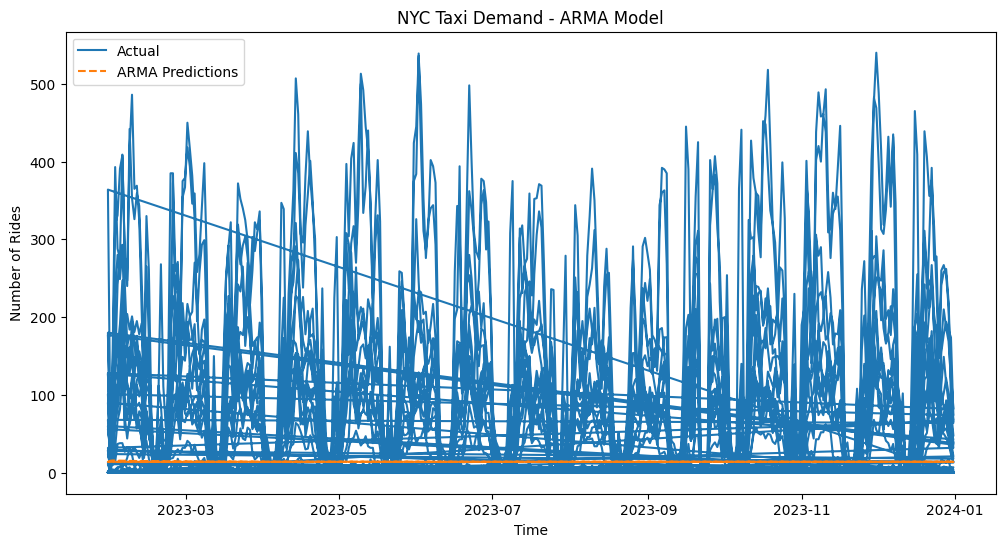

In [38]:
# Step 7: Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, y_pred, label="ARMA Predictions", linestyle="dashed")
plt.legend()
plt.title("NYC Taxi Demand - ARMA Model")
plt.xlabel("Time")
plt.ylabel("Number of Rides")
plt.show()

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
# Step 4: Use Auto ARIMA to find best parameters
auto_model = auto_arima(train, seasonal=False, trace=True, stepwise=True, suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=642440.014, Time=15.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=651056.979, Time=0.61 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=651001.616, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=650967.819, Time=1.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=651054.979, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=642626.838, Time=10.67 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=642773.998, Time=12.25 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=642413.505, Time=23.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=642463.607, Time=15.56 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=641084.564, Time=43.31 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=642351.349, Time=21.26 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=642347.172, Time=42.97 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=642399.613, Time=47.45 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=642439.140, Time=23.97

In [41]:
p, d, q = auto_model.order

# Step 5: Fit ARIMA Model
model = ARIMA(train, order=(p, d, q))
arima_result = model.fit()
print(arima_result.summary())

# Step 6: Forecast on test data
y_pred = arima_result.forecast(steps=len(test))

# Step 7: Evaluate using MAE
mae_arima = mean_absolute_error(test, y_pred)
print(f"ARIMA Model MAE: {mae_arima}")

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                73216
Model:                 ARIMA(4, 1, 2)   Log Likelihood             -321171.222
Date:                Mon, 03 Mar 2025   AIC                         642356.444
Time:                        16:52:26   BIC                         642420.852
Sample:                             0   HQIC                        642376.269
                              - 73216                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0008      0.026     37.936      0.000       0.949       1.052
ar.L2         -0.3134      0.022    -14.108      0.000      -0.357      -0.270
ar.L3          0.1357      0.005     28.796      0.0